In [3]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq ` upgrades to the latest version of 
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# U = upgrade, q = quiet
if iskaggle:
    !pip install -Uqq fastai duckduckgo_search 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 14.0.2 which is incompatible.


## Step 1: Download images of birds and non-birds

In [5]:
from duckduckgo_search import AsyncDDGS

from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    results = AsyncDDGS().images(keywords=term, region='wt-wt', safesearch='off', max_results=max_images)
    return L(results).itemgot('image')

In [6]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
results = search_images('bird photos', max_images=1)
results[0]

Searching for 'bird photos'


'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

### Download url to view the image

#### View an example of bird image

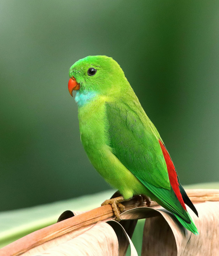

In [7]:
from fastdownload import download_url

dest = 'bird.jpg'
download_url(results[0], dest, show_progress=False)

# view the image
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

#### View an example of forest image 

Searching for 'forest photos'


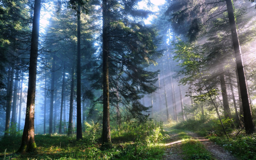

In [8]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

### Grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder

In [9]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    
    download_images(dest, urls= (search_images(f'{o} photo')) )
    sleep(10)  # Pause between searches to avoid over-loading server
    
    download_images(dest, urls=(search_images(f'{o} sun photo')))
    sleep(10)
    
    download_images(dest, urls=(search_images(f'{o} shade photo')))  # parallel process
    sleep(10)
    
    resize_images(path/o, max_size=400, dest=path/o)   # big images take more time to open so decreasing makes opening faster

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train the model

### Remove images that are not downloaded correctly since they can cause our model training to fail

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

To train a model, we'll need `DataLoaders`, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

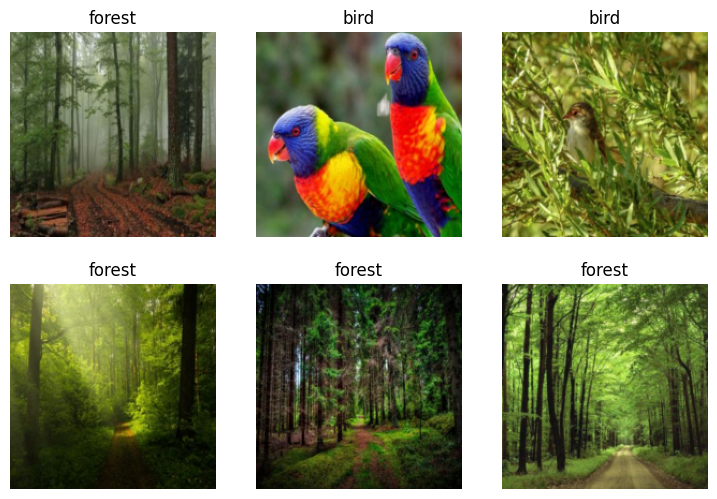

In [11]:
# get data to the model
dls = DataBlock(
    # input: images, output: label or category (1 of the # of possibilities)
    blocks = (ImageBlock, CategoryBlock),
    
    # get_image_files: a function returns a list of all image files in a path
    get_items = get_image_files,
    
    # split to training and validation sets, using 20% of the data for the validation set.
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    
    # parent_label: return parent label of a path ('bird_or_not')
    get_y=parent_label,
    
    # resize each of them by 192x192 pixels
    item_tfms=[Resize(192, method='squish')] 
).dataloaders(path, bs=32)   # dataloaders: iterate and grab bunch of data at a time, use GPU

dls.show_batch(max_n=6)

 #### Train our model with computer vision model: `resnet18`
 
 `fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that

In [12]:
# dls: data loaded subject

"""
explain of Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth"

resnet18 is a pretrained model to recognize 1mil images of different types
"""

learn = vision_learner(dls, resnet18, metrics=error_rate)

learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.055066,0.698321,0.235294,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.146602,0.027249,0.000000,00:01
1,0.110236,0.011844,0.000000,00:01
2,0.072736,0.012063,0.000000,00:00


## Step 3: Use your model

In [13]:
"""
is_bird: bird or not as a string
_: as integer
probs: as probabilities
"""
is_bird, _ , probs = learn.predict(PILImage.create('bird.jpg'))

print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


## Object recognition example

In [15]:
import numpy as np

In [17]:
# load data to path
path2 = untar_data(URLs.CAMVID_TINY)

dls2 = SegmentationDataLoaders.from_label_func(
    path2, bs=8, fnames = get_image_files(path2/"images"),          # get images
    label_func = lambda o: path2/'labels'/f'{o.stem}_P{o.suffix}',  # get parent label
    codes = np.loadtxt(path2/'codes.txt', dtype=str)                
)

# implement learner
learn2 = unet_learner(dls2, resnet34)
learn2.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 154MB/s]


epoch,train_loss,valid_loss,time
0,3.067166,2.288440,00:01


epoch,train_loss,valid_loss,time
0,1.707224,1.596556,00:01
1,1.509901,1.651943,00:01
2,1.418633,1.038577,00:01
3,1.272353,0.886593,00:01
4,1.147190,0.731511,00:01
5,1.032690,0.684465,00:01
6,0.938893,0.677775,00:01
7,0.867338,0.672590,00:01


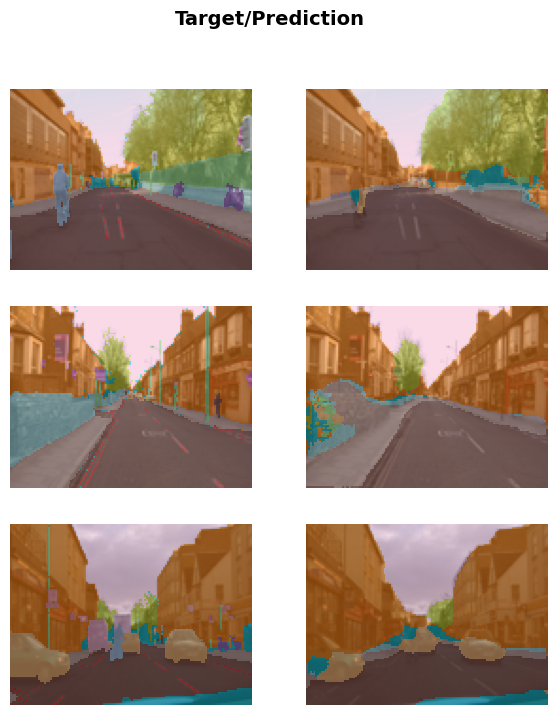

In [18]:
learn2.show_results(max_n=3, figsize=(7,8))

## Tabular data example

In [19]:
from fastai.tabular.all import * 

# get data
path3 = untar_data(URLs.ADULT_SAMPLE)

# implement classifier
dls3 = TabularDataLoaders.from_csv(path3/'adult.csv', path=path3, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],   # identify categorical data
    cont_names = ['age', 'fnlwgt', 'education-num'],    # identify numerical/continuous data
    procs = [Categorify, FillMissing, Normalize]        # imputation and normalize numerical data
)

dls3.show_batch()

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Self-emp-inc,Bachelors,Divorced,Farming-fishing,Not-in-family,White,False,43.0,260959.996962,13.0,<50k
1,Private,Masters,Divorced,Sales,Not-in-family,White,False,74.0,84197.001081,14.0,<50k
2,?,HS-grad,Married-civ-spouse,?,Husband,Black,False,36.0,370585.004952,9.0,<50k
3,Private,Assoc-voc,Divorced,Sales,Not-in-family,White,False,32.0,180871.000285,11.0,>=50k
4,Self-emp-not-inc,HS-grad,Divorced,Exec-managerial,Not-in-family,White,False,51.0,111282.997501,9.0,>=50k
5,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Husband,White,False,36.0,138441.000577,12.0,<50k
6,Private,HS-grad,Never-married,Handlers-cleaners,Own-child,White,False,22.0,99696.998015,9.0,<50k
7,Private,11th,Never-married,Sales,Own-child,White,False,17.0,110723.001130,7.0,<50k
8,Private,HS-grad,Never-married,Other-service,Other-relative,Asian-Pac-Islander,False,25.0,149943.001239,9.0,<50k
9,State-gov,HS-grad,Married-civ-spouse,Adm-clerical,Husband,White,False,65.0,215908.000474,9.0,>=50k


In [20]:
# implement learner
learn3 = tabular_learner(dls3, metrics=accuracy)
learn3.fit_one_cycle(2)      # fit one cycle since we're not using pretrained model and tabular data is different every time, unlike images

epoch,train_loss,valid_loss,accuracy,time
0,0.373472,0.369320,0.830774,00:05
1,0.364552,0.354974,0.838606,00:04


In [23]:
learn3.show_results(max_n=5)

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,10.0,3.0,13.0,1.0,5.0,1.0,-0.408160,-0.536908,1.146518,1.0,1.0
1,5.0,8.0,1.0,2.0,5.0,5.0,1.0,0.399398,-0.788721,0.754024,0.0,0.0
2,5.0,12.0,5.0,8.0,4.0,5.0,1.0,-0.628403,-0.866281,-0.423458,0.0,0.0
3,5.0,10.0,3.0,5.0,1.0,5.0,1.0,0.179155,-0.381080,1.146518,1.0,1.0
4,5.0,13.0,3.0,5.0,1.0,5.0,1.0,0.105740,-0.493241,1.539012,1.0,1.0


## Collaborative filtering - Recommendation system example

In [24]:
from fastai.collab import *

# load data
path4 = untar_data(URLs.ML_SAMPLE)

# implement classifier
dls4 = CollabDataLoaders.from_csv(path4/"ratings.csv")

In [25]:
# show data
dls4.show_batch()

,userId,movieId,rating
0,105,1036,4.0
1,243,3578,4.5
2,648,1580,1.5
3,596,4973,5.0
4,247,2959,5.0
5,355,50,3.5
6,534,2571,4.0
7,423,318,4.0
8,461,1240,4.0
9,292,2571,4.0


In [27]:
# actual range is 1-5, but it's better to set lower and higher than the actual numbers for the learner
learn4 = collab_learner(dls4, y_range=(0.5,5.5))

# fine-tune or fit_one_cycle work the same in this one since no pretrained model is being used
# metric is MSE
learn4.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.507711,1.415067,00:00


epoch,train_loss,valid_loss,time
0,1.319172,1.360444,00:00
1,1.261881,1.202747,00:00
2,1.029035,0.930616,00:00
3,0.829274,0.774899,00:00
4,0.695570,0.730444,00:00
5,0.661370,0.715319,00:00
6,0.620335,0.706149,00:00
7,0.592989,0.702442,00:00
8,0.575731,0.701300,00:00
9,0.592432,0.701128,00:00


In [28]:
learn4.show_results()

,userId,movieId,rating,rating_pred
0,35.0,47.0,3.5,2.956687
1,89.0,82.0,1.0,4.093836
2,65.0,97.0,3.5,3.875722
3,18.0,17.0,2.0,3.267911
4,83.0,47.0,5.0,4.237324
5,56.0,16.0,5.0,4.463353
6,63.0,77.0,3.0,2.932711
7,34.0,2.0,4.0,3.520685
8,17.0,23.0,3.0,3.229180


## Knowledge review
1. Do you need these for deep learning?
* Lots of math T / **F**
* Lots of data T / **F**
* Lots of expensive computers T / **F**
* A PhD T / **F**
<br></br>
2. Name five areas where deep learning is now the best in the world.
* Natural Language Processing (NLP): answering questions, speech recognition, classifying documents
* Computer Vision: face recognition; image captioning; reading traffic signs
* Biology: classifying proteins, cell classification
* Medicine: finding anomalies in radiology images, including CT, MRI, and X-ray images
* Recommendation systems: Web search, product recommendations
<br></br>
3. What was the name of the first device that was based on the principle of the artificial neuron?
* Mark I Perceptron
<br></br>
4. Based on the book of the same name, what are the requirements for parallel distributed processing (PDP)?
* A set of processing units
* A state of activation
* An output function for each unit
* A pattern of connectivity among units
* A propagation rule for propagating patterns of activities through the network of connectivities
* An activation rule for combining the inputs impinging on a unit with the current state of that unit to produce an output for the unit
* A learning rule whereby patterns of connectivity are modified by experience
* An environment within which the system must operate
<br></br>
5. What were the two theoretical misunderstandings that held back the field of neural networks?
* A single layer of these devices was unable to learn some simple but critical mathematical functions (such as XOR)
* Adding just one extra layer of neurons was enough to allow any mathematical function to be approximated. However, in practice, these networks were too big and slow. While it was demonstrated that adding additional layers improved performance, this insight was not acknowledged, and the second AI winter began. In this past decade, with increased data availability, and improvements in computer hardware (both in CPU performance but more importantly in GPU performance), neural networks are finally living up to its potential.
<br></br>
6. What is a GPU?
* Graphics Processing Unit or graphic cards
* a special kind of processor that can handle thousands of single tasks at the same time, especially designed for displaying 3D environments on a computer for playing games
* These same basic tasks are very similar to what neural networks do, such that GPUs can run neural networks hundreds of times faster than regular CPUs. All modern computers contain a GPU, but few contain the right kind of GPU necessary for deep learning
<br></br>
* Skip 7 to 9 since they are Jupyter Notebook focus tasks
<br></br>
10. Why is it hard to use a traditional computer program to recognize images in a photo?
* Because it's impossible to define set rules for a traditional computer program to recognize images 
<br></br>
11. What did Samuel mean by "weight assignment"?
* "weight assignment" refers to the current values of the model parameters. This refers to the evaluation and training of the model in order to obtain a set of parameter values that maximizes model performance.
<br></br>
12. What term do we normally use in deep learning for what Samuel called "weights"?
* Parameters
<br></br>
13. Why is it hard to understand why a deep learning model makes a particular prediction?
* Because it's like a black box, and it's not interpretable like machine learning models (e.g, Random Forest model)
<br></br>
14. What is the name of the theorem that shows that a neural network can solve any mathematical problem to any level of accuracy?
*  Universal approximation theorem states that neural networks can theoretically represent any mathematical function 
<br></br>
15. What do you need in order to train a model?
* Labeled data, loss function to quantitatively measure the performance of your model, and a way to update the parameters of the model in order to improve its performance, or finding optimal hyperparameters
<br></br>
16. How could a feedback loop impact the rollout of a predictive policing model?
* In a predictive policing model, we might end up with a positive feedback loop, leading to a highly biased model with little predictive power. However, this data itself is slightly biased due to the biases in existing policing processes. Training with this data leads to a biased model. Law enforcement might use the model to determine where to focus police activity, increasing arrests in those areas. These additional arrests would be used in training future iterations of models, leading to an even more biased model. This cycle continues as a positive feedback loop
<br></br>
17. Do we always have to use 224×224-pixel images with the cat recognition model?
* No, but it's recommended since it takes less time to load the image and due to historical reasons
<br></br>
17. What is the difference between classification and regression?
* Classification is for predicting class or category
* Regression is for predicting continuous data or numeric quantity
<br></br>
18. What is a validation set? What is a test set? Why do we need them?
* Validation set is to evaluate model's performance during training to prevent overfitting
* Test set is for final evaluation of model's performance, to ensure that the model generalizes to unseen data
<br></br>
19. What will fastai do if you don't provide a validation set?
* `fastai` will automatically create a validation dataset. It will randomly take 20% of the data and assign it as the validation set
<br></br>
20. Can we always use a random sample for a validation set? Why or why not?
* A good validation or test set should be representative of new data you will see in the future. Sometimes this isn’t true if a random sample is used. For example, for time series data, selecting sets randomly does not make sense. Instead, defining different time periods for the train, validation, and test set is a better approach
<br></br>
21. What is overfitting? Provide an example.
* Overfitting refers to when the model fits too closely to a limited set of data but does not generalize well to unseen data.  
* This is especially important when it comes to neural networks, because neural networks can potentially “memorize” the dataset that the model was trained on, and will perform terribly on unseen data because it didn’t “memorize” the ground truth values for that data. This is why a proper validation framework is needed by splitting the data into training, validation, and test sets
<br></br>
22. What is a metric? How does it differ from "loss"?
* Metric is used to assess how well the model is doing on the validation set
* Loss is to define a "measure of performance" that the training system can use to update weights automatically. 
* In other words, a good choice for loss is a choice that is easy for stochastic gradient descent to use. But a metric is defined for human consumption, so a good metric is one that is easy for you to understand,
<br></br>
23. How can pretrained models help?
* Pretrained models are useful regardless of the details of your project. They have already learned how to handle a lot of simple features like edge and color detection. However, since the model was trained for a different task than already used, this model cannot be used as is
<br></br>
24. What is the "head" of a model?
* Layers with randomized weights of an appropriate size for the dataset you are working with
<br></br>
25. What kinds of features do the early layers of a CNN find? How about the later layers?
* Earlier layers learn simple features like diagonal, horizontal, and vertical edges 
* Later layers learn more advanced features like car wheels, flower petals, and even outlines of animals
<br></br>
26. Are image models only useful for photos?
* They are also useful for sketches, medical data, etc as a lot of information can be represented as images 
<br></br>
27. What is an "architecture"?
* The template of the model that we're trying to fit; the actual mathematical function that we're passing the input data and parameters to
<br></br>
28. What is segmentation?
* A pixelwise classification problem. We attempt to predict a label for every single pixel in the image; recognize the content of every individual pixel in an image
<br></br>
29. What is `y_range` used for? When do we need it?
* To define a range for the model to predict for regression type of problem
<br></br>
30. What are "hyperparameters"?
* Training models requires various other parameters that define how the model is trained
<br></br>
31. What's the best way to avoid failures when using AI in an organization?
* Make sure a training, validation, and testing set is defined properly in order to evaluate the model in an appropriate manner
* Try out a simple baseline, which future models should hopefully beat. Or even this simple baseline may be enough in some cases